In [1]:
import numpy as np
import matplotlib.pyplot as plt
from network_analysis import network_tools as nt
# make figures crisp
%config InlineBackend.figure_format = 'retina'

# General parameters
We first set general parameters of our network.

Namely, we define the characteristic impedance $Z_0$ and the speed of light in the transmission lines $\nu_p$ (a.k.a. phase velocity).

In [2]:
# Parameters
c = 3e8                     # speed of light in vaccum
eps_r = 11.45               # relative permeability of our substrate
vp = c/np.sqrt((1+eps_r)/2) # speed of light in the transmission line
Z0 = 50                     # characteristic impedance

# Setup microwave network
We can setup a microwave network using the "Network" instance of the network_tools library.

Elements such can be added to the network using the network.add_* methods. These include:
- capacitors (series or parallel)
- inductors (series or parallel)
- resistors (series or parallel)
- transmission lines (series or parallel)
- attenuators
- amplifiers
- capacitively coupled resonators
- inductively coupled resonators

In the following, we setup an example network and used the "draw_network" method to visualize it.
The scattering parameters of the network can be obtained using the "get_S_parameters" method.

## Available components list

### Resistors, Inductors and Capacitors

Standard lumped element components include resistors, inductors and capacitors. These can be arranged in series or in parallel.

#### Eg.1: RC Low pass filter

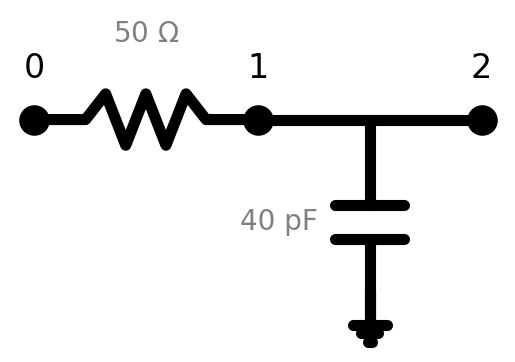

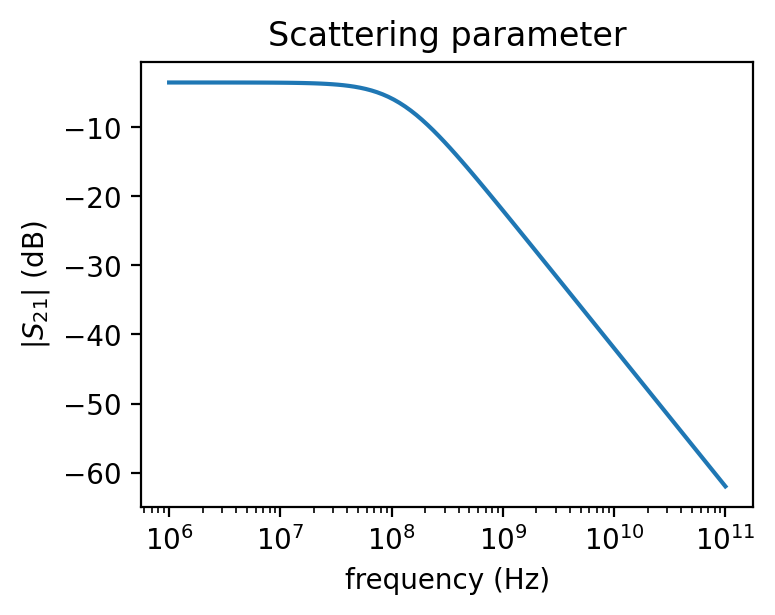

In [3]:
# setup network instance
network = nt.Network(Zgen=Z0)

# add elements
network.add_resistor(R=50, element_type='series')
network.add_capacitance(C=40e-12, element_type='parallel')

# draw network schematic
network.draw_network()

# plot s21 of network
s11, s12, s21, s22 = network.get_S_parameters(frequency=np.logspace(6, 11, 100), plot='s21', yscale='dB', xscale='log')

#### Eg.2: RLC band pass filter

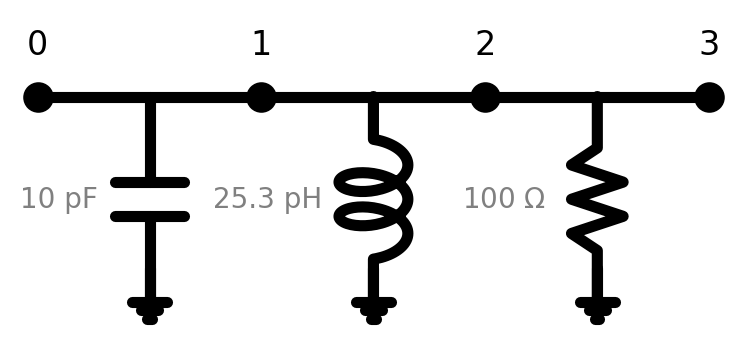

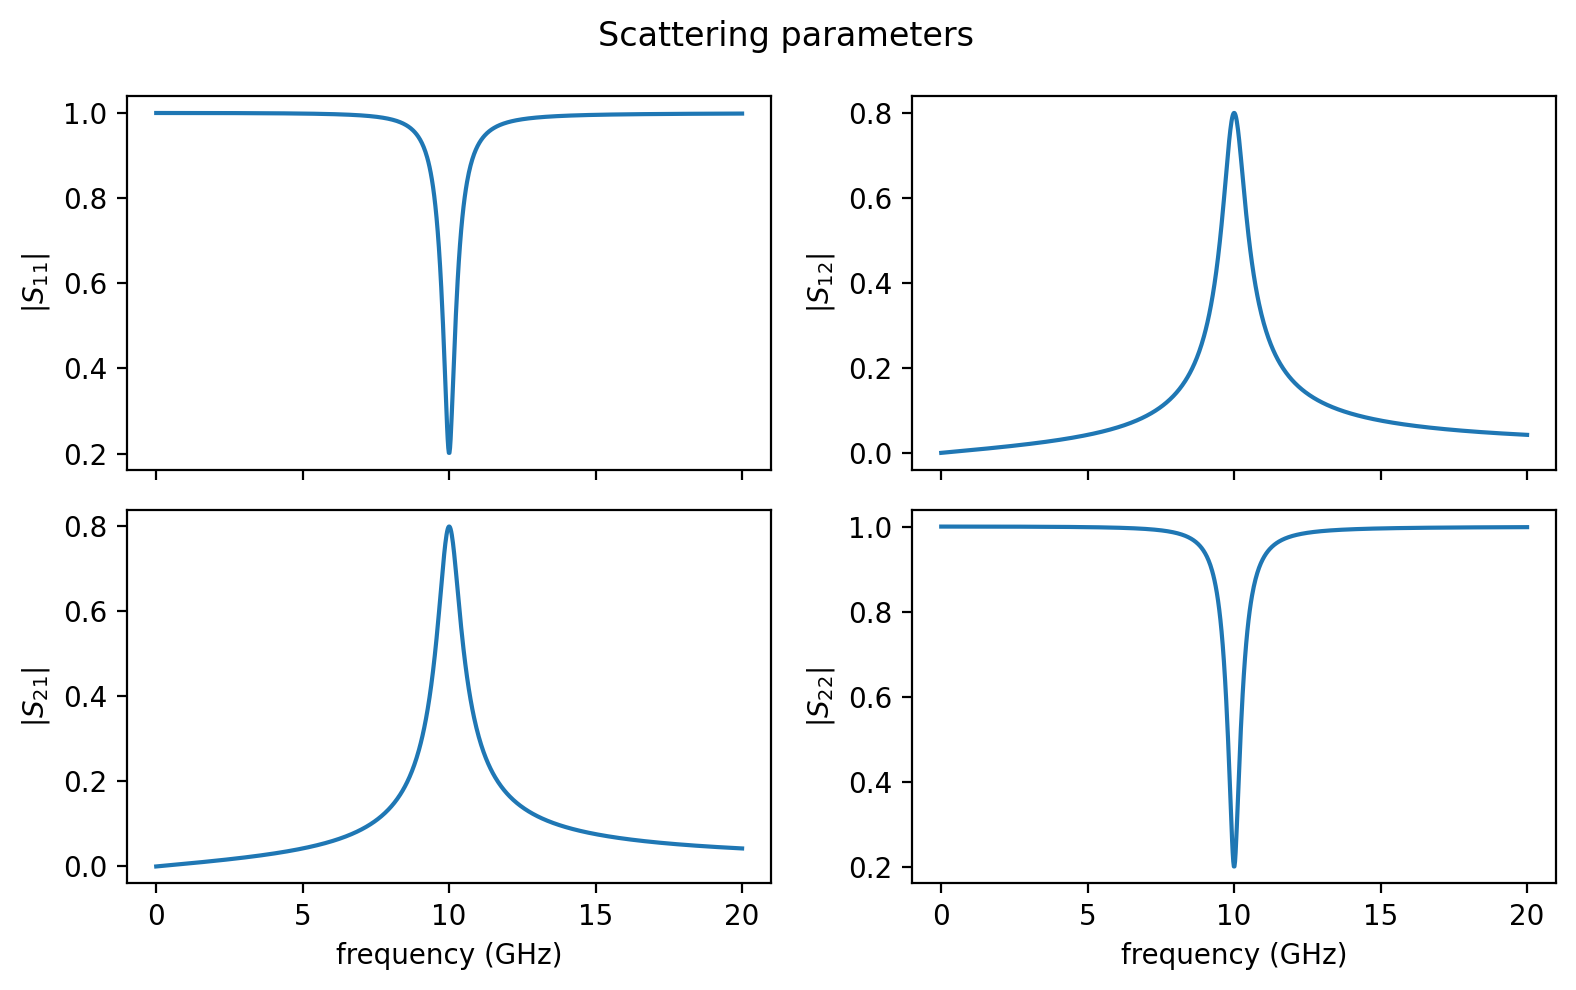

In [4]:
# compute element requirements for resonance frequency
resonance_frequency = 10e9
C = 10e-12
L = 1/(C* (2*np.pi*resonance_frequency)**2 )

# setup network instance
network = nt.Network(Zgen=Z0)
network.add_capacitance(C=C, element_type='parallel')
network.add_inductance(L=L, element_type='parallel')
network.add_resistor(R=1e2, element_type='parallel')
network.draw_network()
s11, s12, s21, s22 = network.get_S_parameters(frequency=np.linspace(1,20e9,1000), plot=True)

### Transmission lines
Distributed elements can be modeled using transmission lines. These can be added in series:

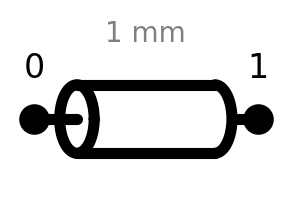

In [5]:
# setup network instance
network = nt.Network(Zgen=Z0)
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

or in parallel (a.k.a. stubs). In the case of parallel lines we must specify the load impedance at the end of the node.

This can be:
* open $Z_\mathrm{load}=\infty$
* shorted $Z_\mathrm{load}=0$
* arbitrary $Z_\mathrm{load}=Z$

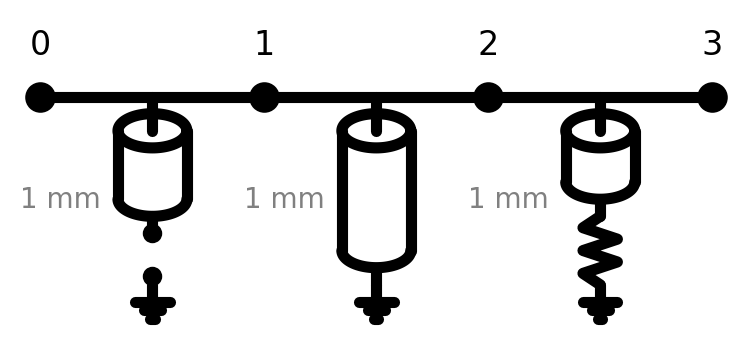

In [6]:
# setup network instance
network = nt.Network(Zgen=Z0)
network.add_parallel_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp, Z_load=1e10)
network.add_parallel_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp, Z_load=0)
network.add_parallel_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp, Z_load=50)
network.draw_network()

### Transformer

An electrical transformer using two coupled inductors.

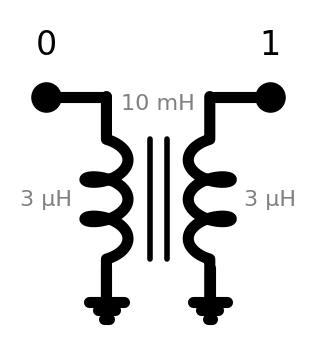

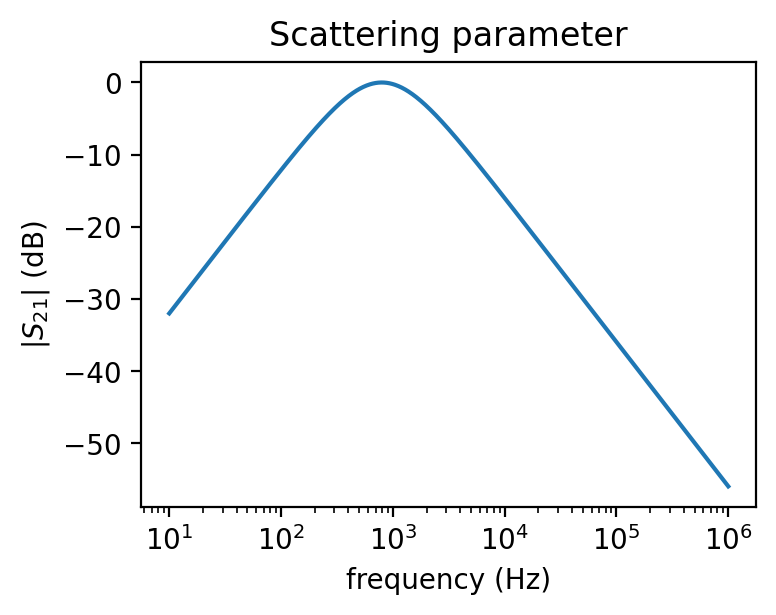

In [7]:
L = 3e-6 # inductor value
M = 1e-2  # mutual inductance between inductors value

# setup network instance
network = nt.Network(Zgen=Z0)
network.add_transformer(L1=L, L2=L, M=M)
network.draw_network()

s11, s12, s21, s22 = network.get_S_parameters(frequency=np.logspace(1,6,1001), plot='s21', xscale='log', yscale='dB')

### Capacitively coupled resonator

A capacitively coupled hanger in parallel used to model $\lambda/4$ or $\lambda/2$ resonators.

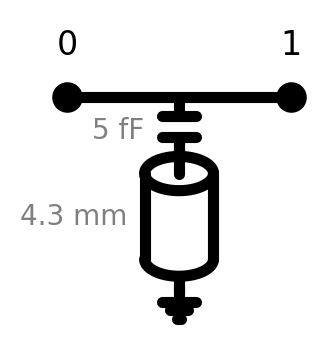

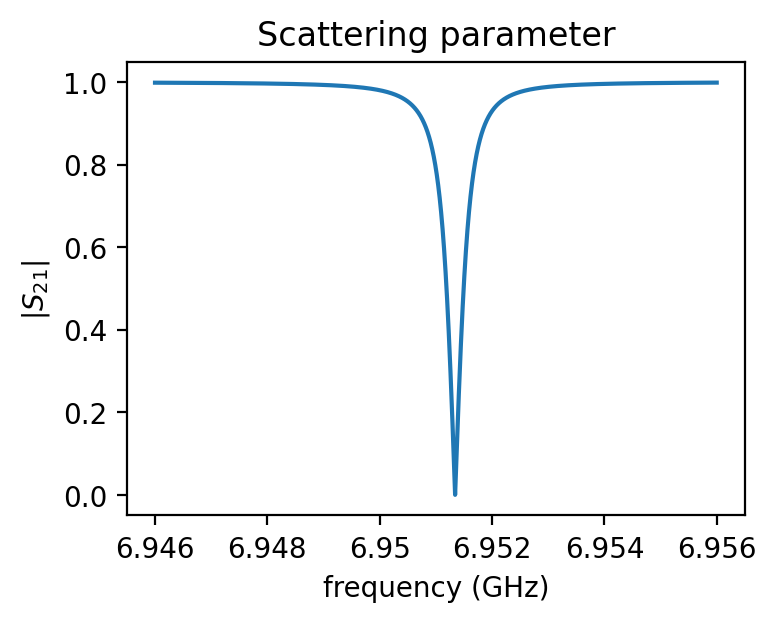

In [8]:
# compute length required for lambda.4 resonator
f0 = 7e9
resonator_length = vp/4/f0
# correction to resonator frequency from capacitor
C_res = 5e-15 # capacitive coupling
f_corr = f0 - 4*Z0*C_res*f0**2

# setup network instance
network = nt.Network(Zgen=Z0)
network.add_capacitively_coupled_hanger(length=resonator_length, Z0=Z0, phase_velocity=vp, Z_termination=0, C_coupling=C_res)
network.draw_network()

s11, s12, s21, s22 = network.get_S_parameters(frequency=np.linspace(-5e6, 5e6,10000)+f_corr , plot='s21')

### Inductively coupled resonator

An inductively coupled hanger in parallel used to model $\lambda/4$ or $\lambda/2$ resonators.

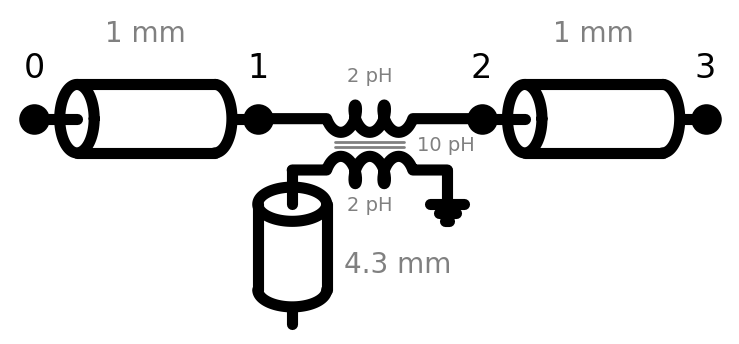

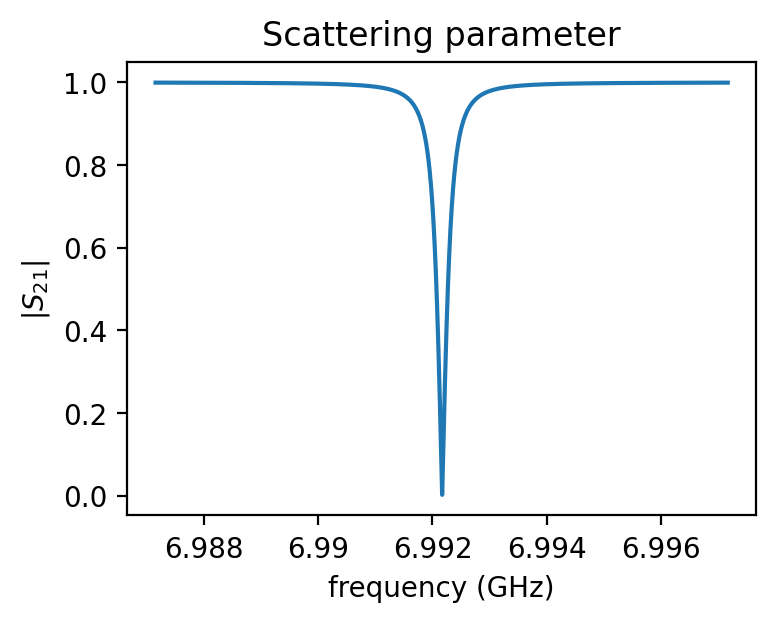

In [9]:
# compute length required for lambda.4 resonator
f0 = 7e9
resonator_length = vp/4/f0
# correction to resonator frequency from capacitor
L = 2e-12 # inductor value
M = 1e-11 # mutual inductance between inductors value
f_corr = f0 - 4*L/Z0*f0**2

# setup network instance
network = nt.Network(Zgen=Z0)
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.add_inductively_coupled_hanger(length=resonator_length, Z0=Z0, phase_velocity=vp,
                                       L_line=L, L_hanger=L, M_inductance=M, Z_termination=1e10)
network.add_transmission_line(length=1e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

s11, s12, s21, s22 = network.get_S_parameters(frequency=np.linspace(-5e6, 5e6,10000)+f_corr , plot='s21')

### Amplifiers and attenuators

Composite components such as attenuators and amplifiers are also available. These are implemented as resistor $\pi$-networks.

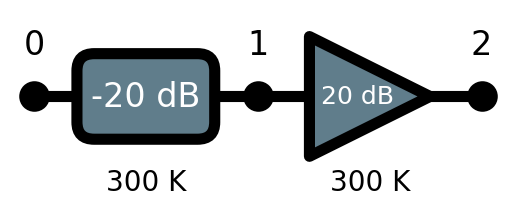

In [10]:
# setup network instance
network = nt.Network(Zgen=Z0)
network.add_attenuator(attn_dB=20, Z0=50, temperature_K=300)
network.add_amplifier(gain_dB=20, Z0=50, temperature_K=300)
network.draw_network()

## Custom components

Some custom components can be added to this library using the standard measurement file format `.s2p`.
Such files can be obtained from manufacturers datasheets (eg. https://www.minicircuits.com/WebStore/dashboard.html?model=SLP-50%2B&srsltid=AfmBOoo_zzyOJ2QB_0s1uFt5a_lvFSy9ty_q_vqD4MIbur68n0FQQfzo). 
Alternatively, these files can be obtained from VNA measurements of the full scattering parameters.

See `.\circuit_components\` directory for available components.

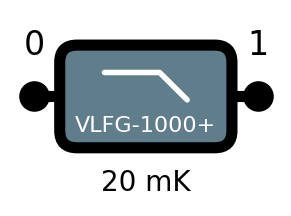

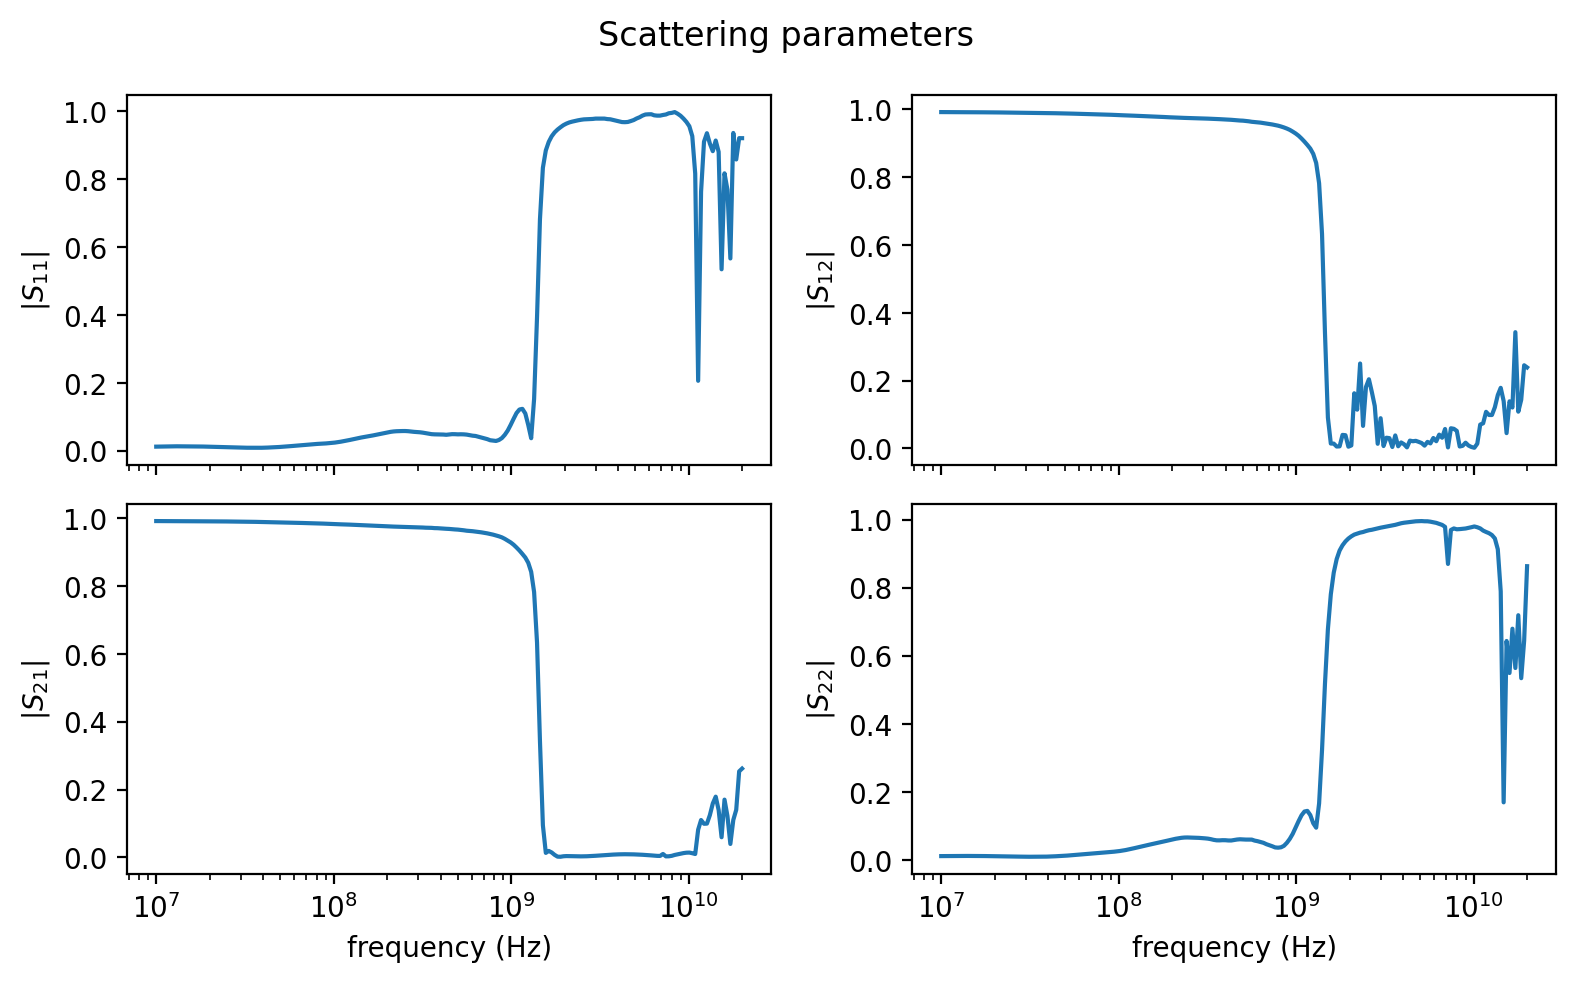

In [11]:
# Example: Mini circuits' VLFX-1000+ low pass filter
network = nt.Network(Zgen=Z0)
network.add_custom_component('VLFG-1000+', temperature_K=20e-3)
network.draw_network()
s11, s12, s21, s22 = network.get_S_parameters(frequency=np.logspace(7, 10.3, 201), plot=True, xscale='log')

# Network properties

After a network instance has been setup, we can extract the following properties from it:
- Scattering matrix, $S_{ij}$
- Impedance matrix, $Z_{ij}$
- Voltage and current phasors
- Signal response
- Power spectral density

## Scattering matrix

An example of scattering parameters for a input capacitance transmission line. The scattering matrix, $S_{ij}$, of the network is calculated using the `get_S_parameters` method. The argument `plot=True` can be used to plot the all the $S_{ij}$ parameters or `plot='s_21'` for a single scattering parameter.

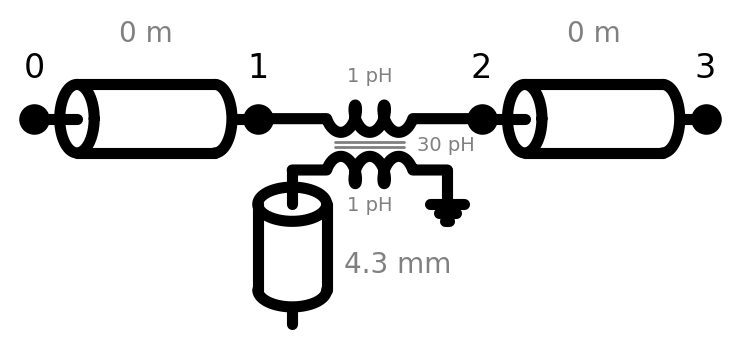

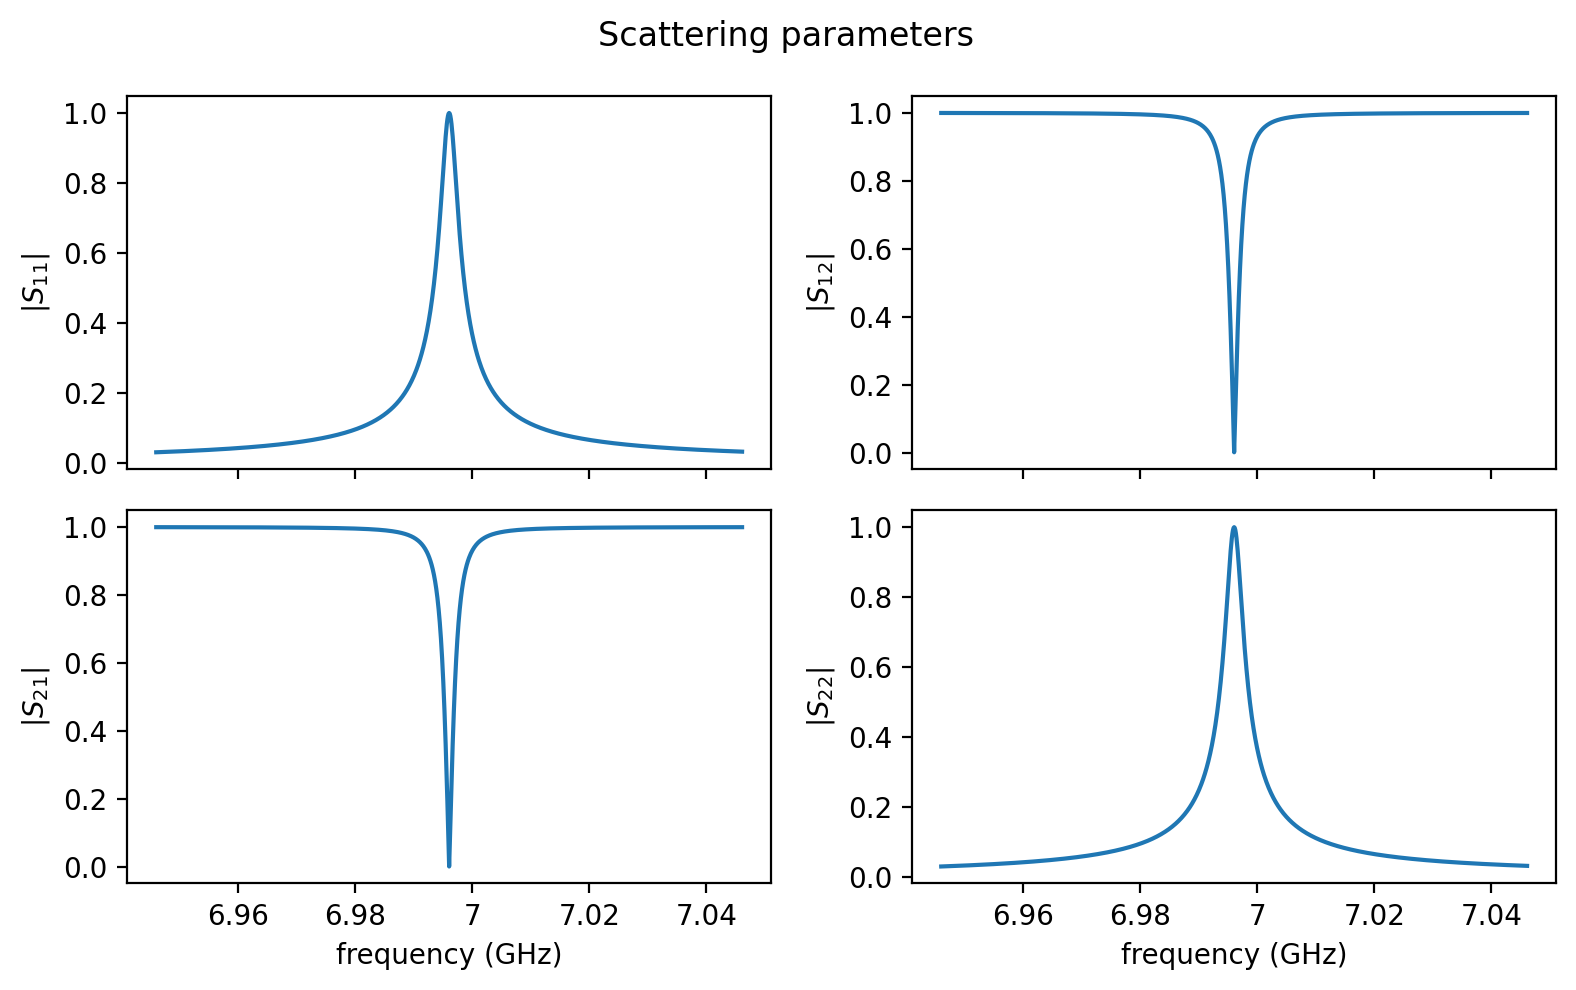

In [12]:
# Setup network
network = nt.Network(Zgen=Z0)

# length of resonator at 9 GHz
f_res = 7e9 
l_res = vp/(4*f_res)
# correction to resonator frequency from mutual inductance
M_ind = 3e-11  # mutal inductance between lines
L_char = 1e-12 # inductance of lines
f_corr = f_res - 4*L_char/Z0*f_res**2

network.add_transmission_line(length=0e-3, Z0=Z0, phase_velocity=vp)
network.add_inductively_coupled_hanger(length=l_res, Z0=Z0 ,phase_velocity=vp, 
                                       L_line=L_char, L_hanger=L_char, M_inductance=M_ind, Z_termination=1e10)
network.add_transmission_line(length=0e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

# frequency axis
freq_axis = f_corr + np.linspace(-50e6, +50e6, 1001)
# scattering parameters
S_pars = network.get_S_parameters(frequency=freq_axis, plot=True)

## Impedance matrix

The impedance matrix, $z_{ij}$, as well as the loaded input and output impedances, $Z_\mathrm{in}$ and $Z_\mathrm{out}$, of the network are calculated using the `get_Z_parameters` method. The argument `plot=True` can be used to plot the all the $Z_{ij}$ parameters or `plot='z_in'` for a single impedance parameter.

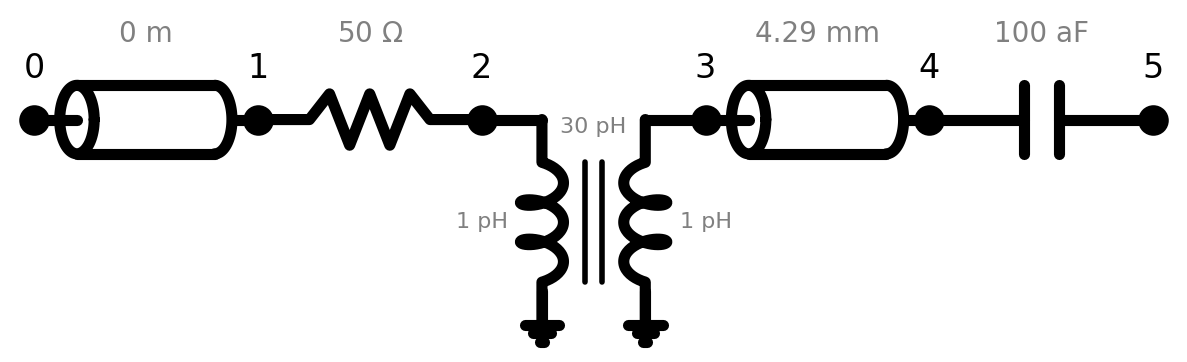

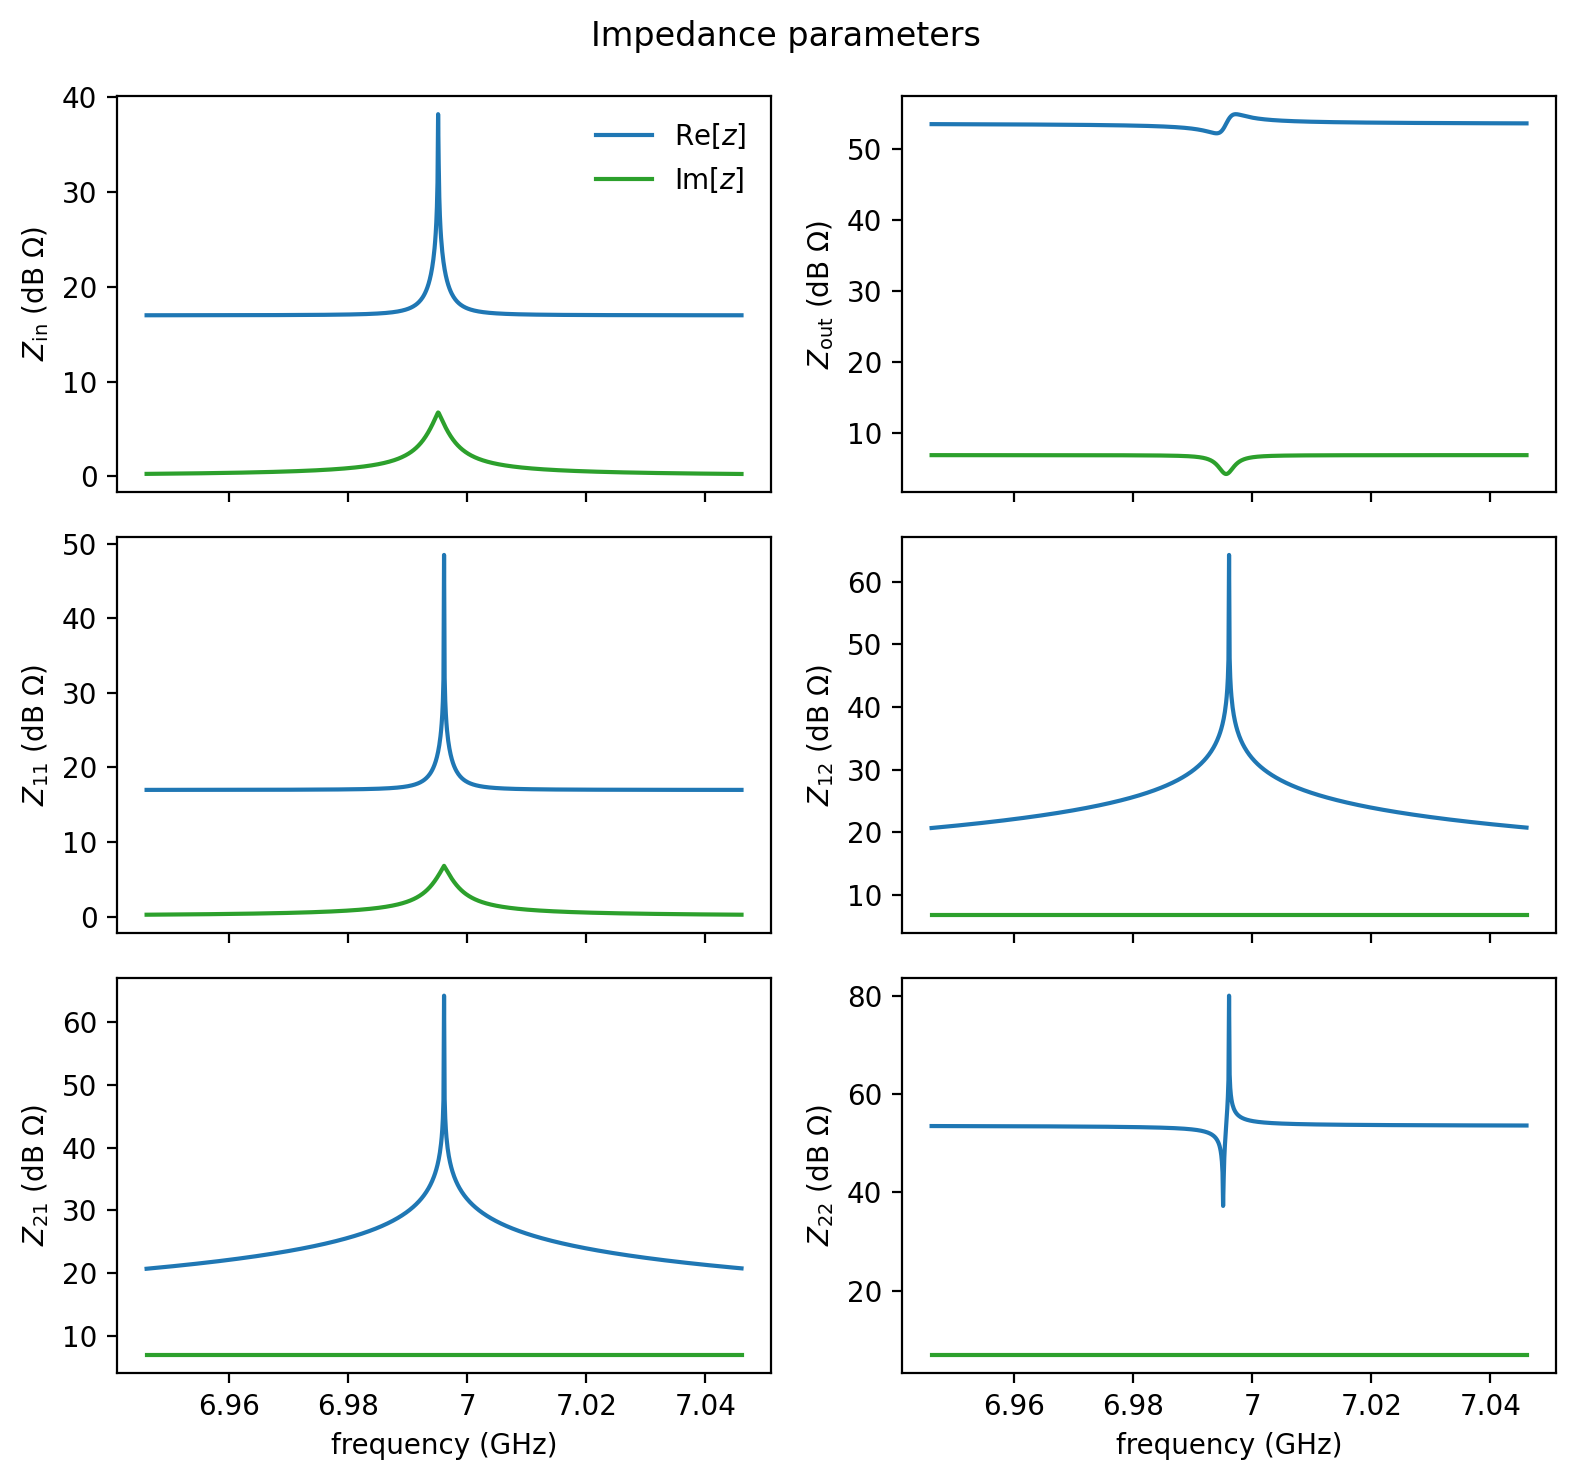

In [13]:
# capacitance seen by the qubit
C_g = .1e-15 # capacitance in Farads
# Setup network
network_qubit = nt.Network(Zgen=Z0)
network_qubit.add_transmission_line(length=0e-3, Z0=Z0, phase_velocity=vp)
network_qubit.add_resistor(R=50, element_type='series')
network_qubit.add_transformer(L1=L_char, L2=L_char, M=M_ind)
network_qubit.add_transmission_line(length=l_res, Z0=Z0, phase_velocity=vp)
network_qubit.add_capacitance(C=C_g, element_type='series')
network_qubit.draw_network()

# frequency axis
freq_axis = f_corr + np.linspace(-50e6, +50e6, 1001)
# scattering parameters
Z_pars = network_qubit.get_Z_parameters(frequency=freq_axis, plot=True, yscale='dB')

## Node power

For a given input signal, voltage and current can be computed at each node using the `get_node_power` method. The input signal is given in power (`in_power_dBm`) and generated accross the network's generator impedance `Zgen`.

In the following, we show an example of this for a readout amplification chain.

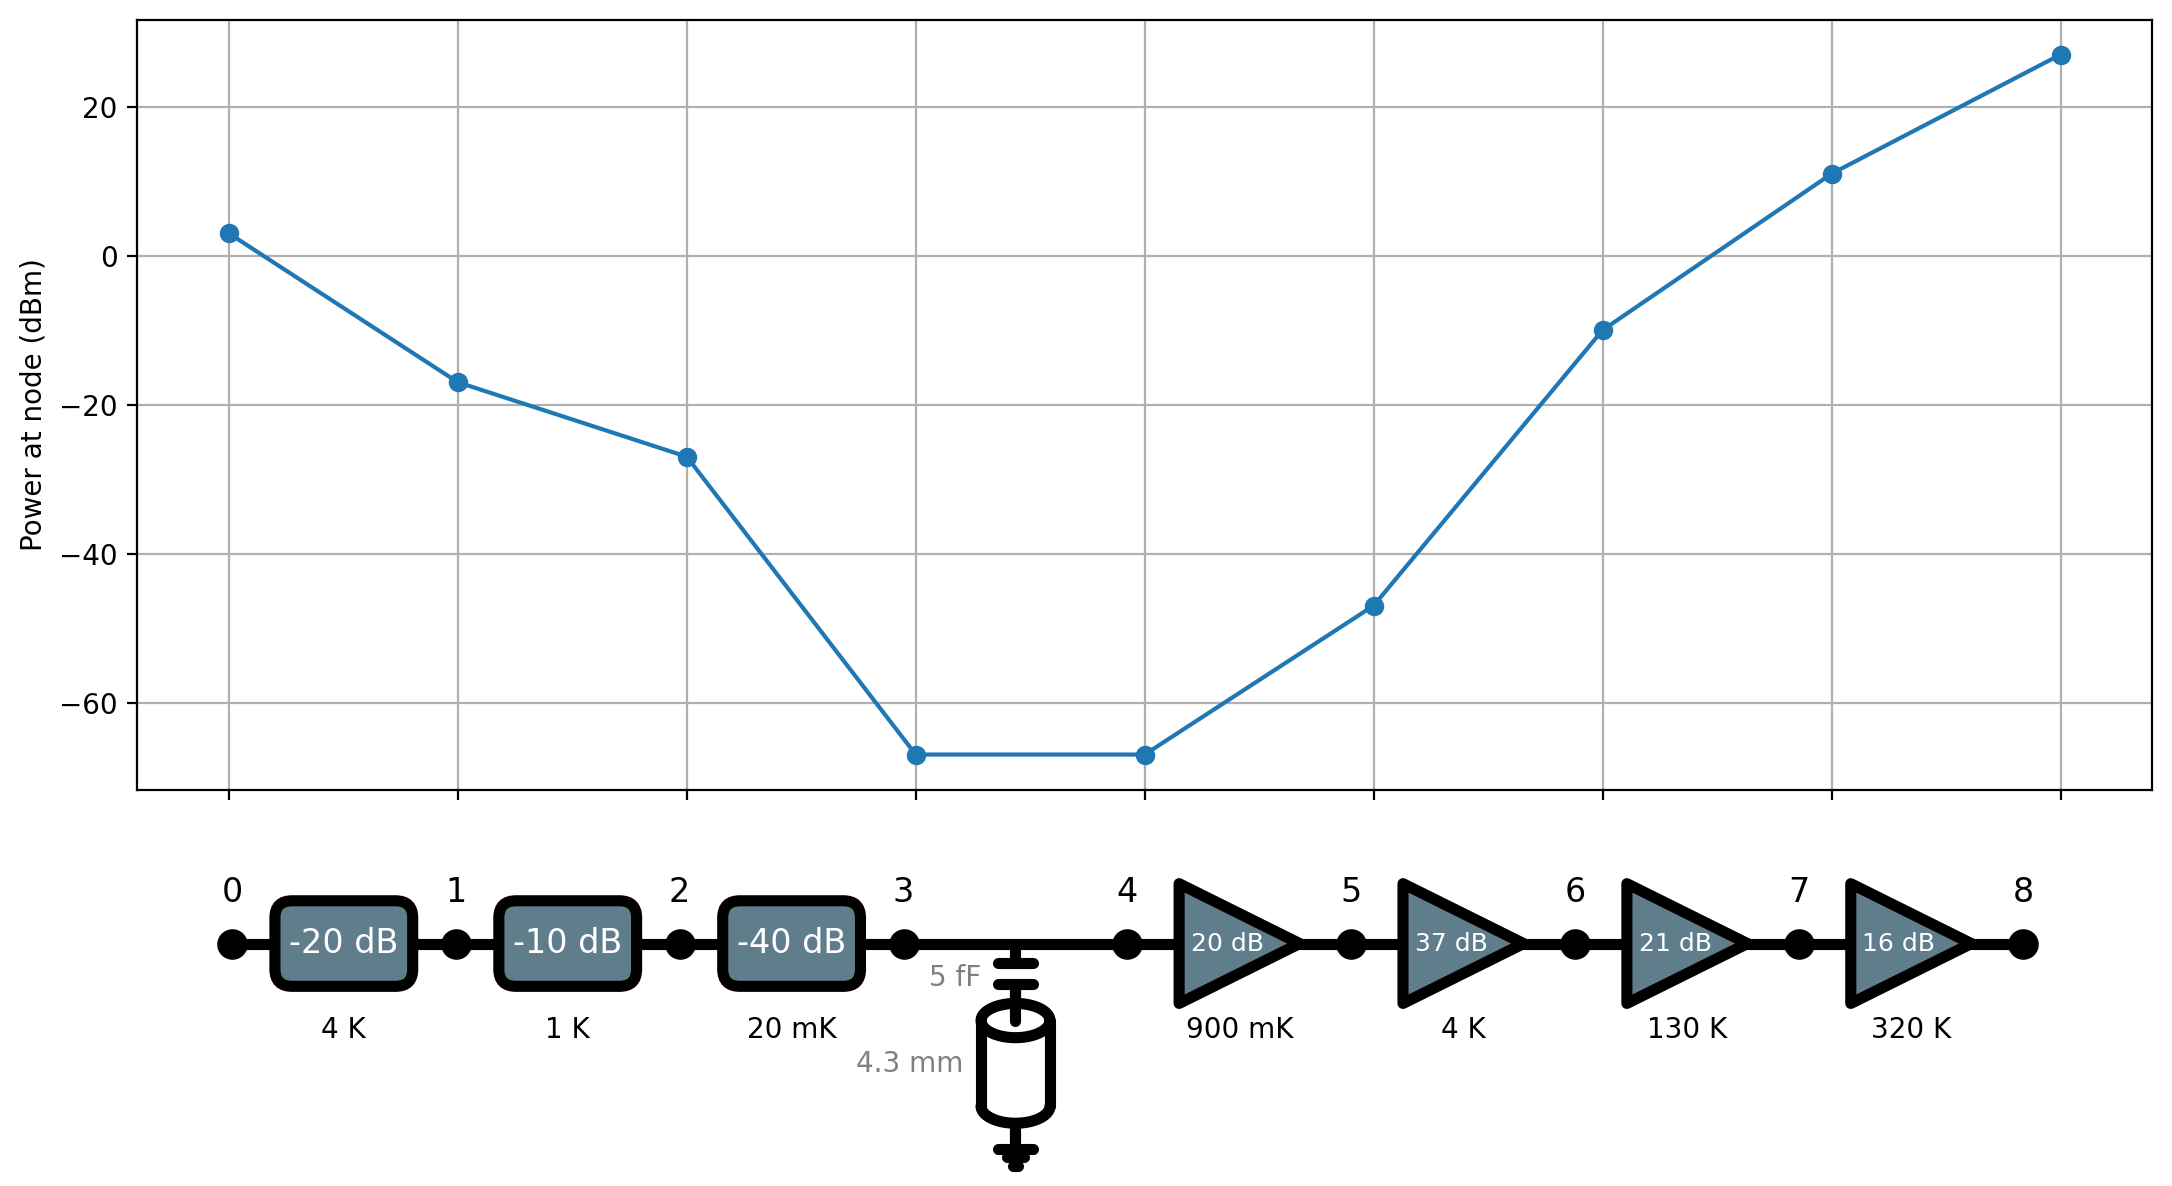

In [14]:
# Setup network
network = nt.Network(Zgen=Z0)
# input attenuation
network.add_attenuator(attn_dB=20, temperature_K=4, Z0=Z0)     # 4K 
network.add_attenuator(attn_dB=10, temperature_K=1, Z0=Z0)     # still
network.add_attenuator(attn_dB=40, temperature_K=20e-3, Z0=Z0) # MXC
# resonator network
network.add_capacitively_coupled_hanger(length=resonator_length, Z0=Z0, phase_velocity=vp, Z_termination=0, C_coupling=C_res)
# output gain
network.add_amplifier(gain_dB=20, temperature_K=900e-3, Z0=Z0) # MXC
network.add_amplifier(gain_dB=37, temperature_K=4.0, Z0=Z0)    # 4 K
network.add_amplifier(gain_dB=21, temperature_K=130, Z0=Z0)    # RT pre-amp (Xmicrowave) (noise-figure 1.4-1.8 dB)
network.add_amplifier(gain_dB=16, temperature_K=320, Z0=Z0)    # RT post-amp

_ = network.get_node_power(node_idx=8, in_power_dBm=0, frequency=8e9, plot=True)

## Node voltage and current

For a given input signal, voltage and current can be computed at each node using the `get_node_VI` method. The input signal is given in power (`in_power_dBm`) and generated accross the network's generator impedance `Zgen`.

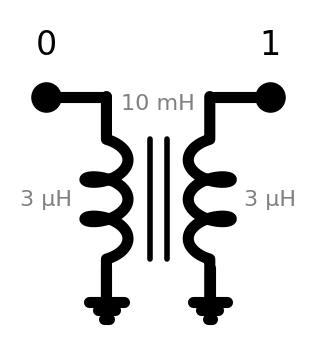

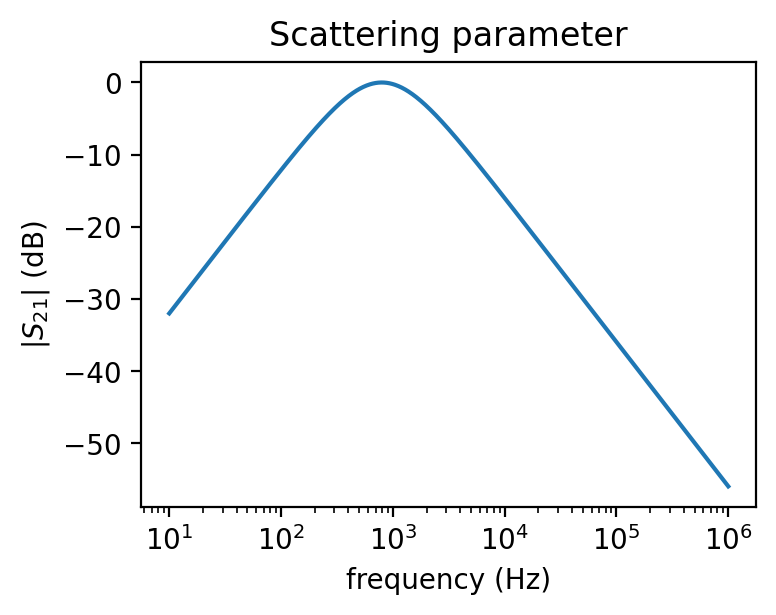

In [15]:
L = 3e-6 # inductor value
M = 1e-2  # mutual inductance between inductors value

# setup network instance
network = nt.Network(Zgen=Z0)
network.add_transformer(L1=L, L2=L, M=M)
network.draw_network()

# scattering parameters
S_pars = network.get_S_parameters(frequency=np.logspace(1,6,1001), plot='s21', xscale='log', yscale='dB')

## Signal response

The time domain response of the network for a given input pulse can be computed using the `get_signal_response` method. This can be used to estimate pulse transients

The the following example, we solve for the response of a resonator to a slightly off-resonant drive.

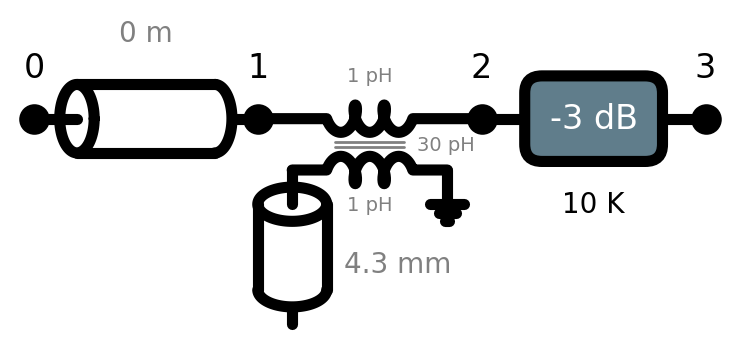

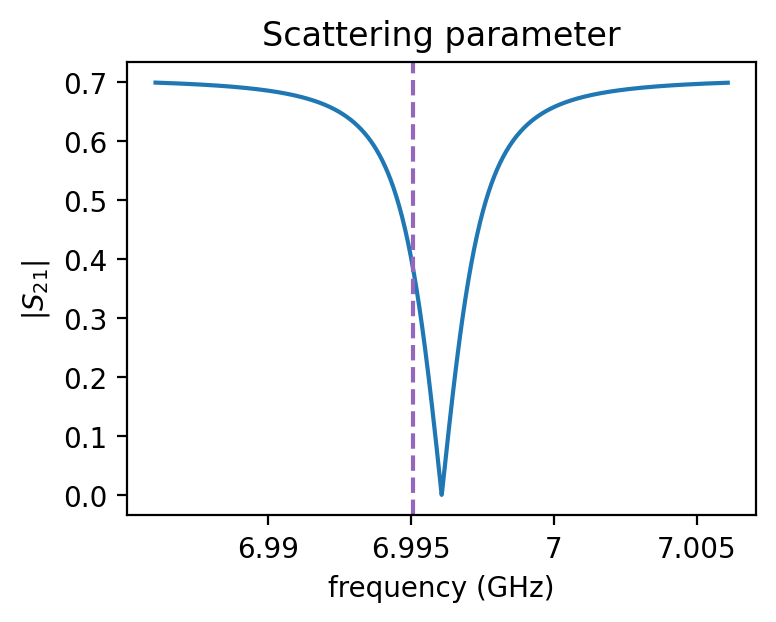

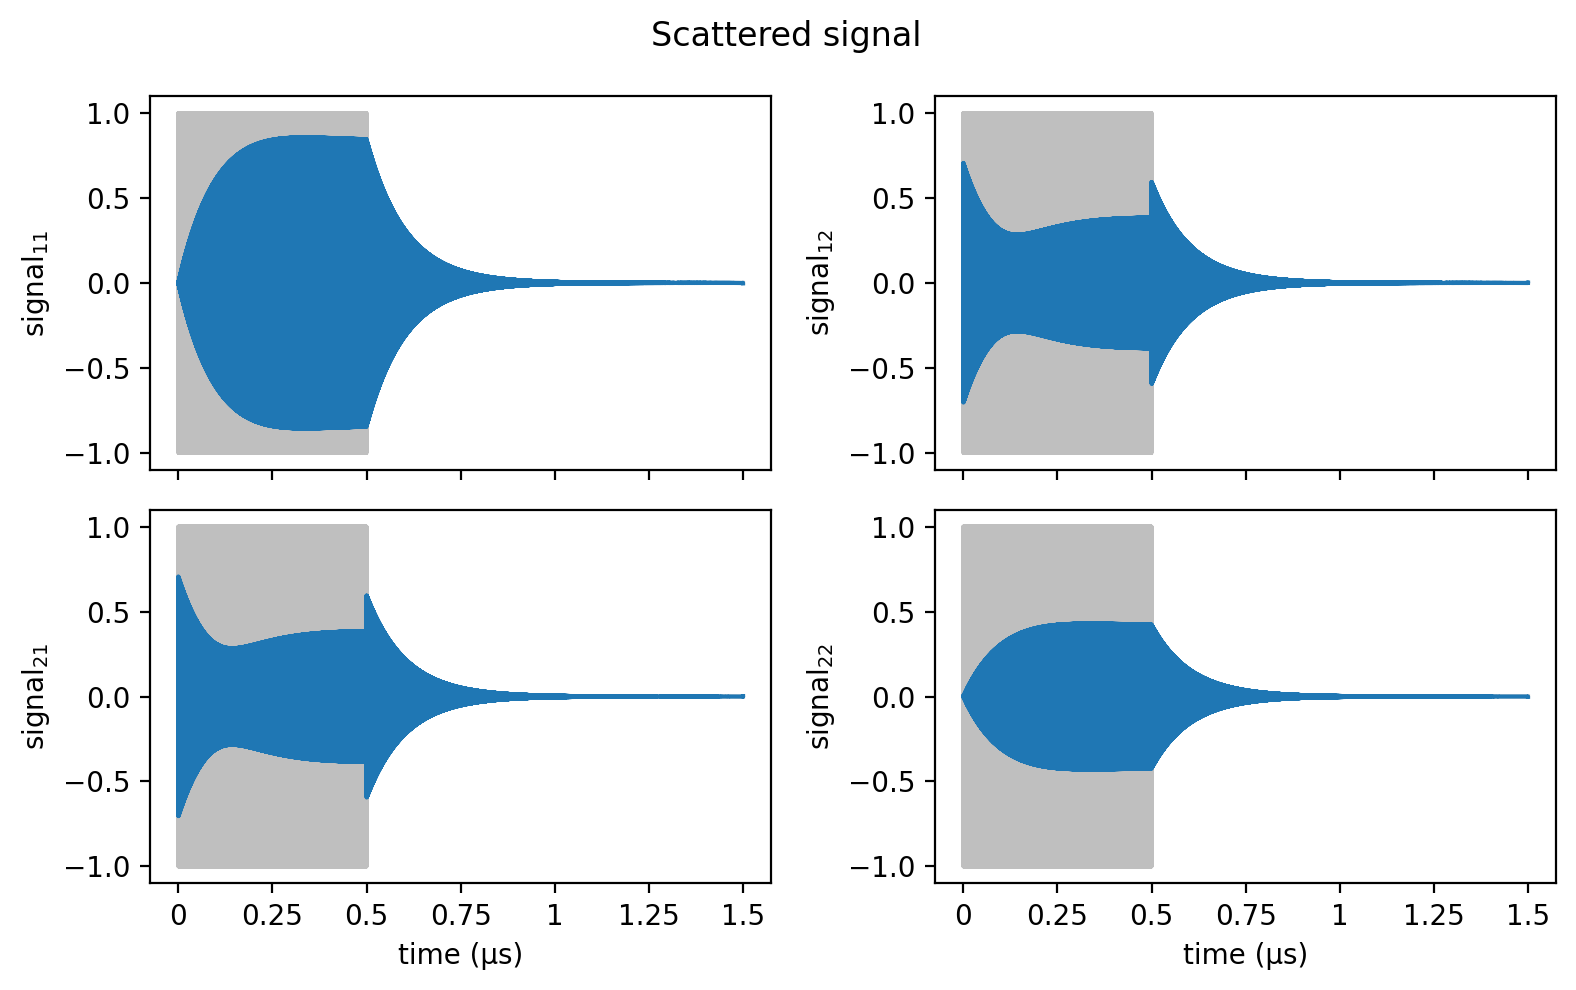

In [16]:
# length of resonator at\ 9 GHz
f_res = 7e9 
l_res = vp/(4*f_res)
# correction to resonator frequency from mutual inductance
M_ind = 3e-11  # mutal inductance between lines
L_char = 1e-12 # inductance of lines
f_corr = f_res - 4*L_char/Z0*f_res**2
drive_frequency = f_corr-1e6

# Setup network
network = nt.Network(Zgen=Z0)
network.add_transmission_line(length=0, Z0=Z0, phase_velocity=vp)
network.add_inductively_coupled_hanger(length=l_res, Z0=Z0 ,phase_velocity=vp, 
                                       L_line=L_char, L_hanger=L_char, M_inductance=M_ind, Z_termination=1e10)
network.add_attenuator(attn_dB=3, Z0=Z0, temperature_K=10)
network.draw_network()

# plot s21
network.get_S_parameters(frequency=np.linspace(-10e6, 10e6, 1001)+f_corr, plot='s21')
plt.gca().axvline(drive_frequency, color='C4', ls='--')

# input signal
time = np.arange(0, 1.5e-6, .01e-9)
input_signal = nt.square_pulse(time, pulse_duration=.5e-6, frequency=drive_frequency)
# calculate scattered signal
_ = network.get_signal_response(time, input_signal, plot=True)

## Thermal noise

Some components may have a temperature associated with them. This can be used to estimate noise properties at certain nodes of the network, namely, the thermal noise power spectral density and other quantities derived from it.

The method `get_psd_at_node` is used to calculate the cascaded power spectral desity at a given network node for an input node temperature `initial_node_temp`.
To compute the cascaded PSD at node, $i$, we follow,

$ S(\omega)_i = (1-\mathrm{A})\:S_{T_{i}} + \mathrm{A}\:S_{i-1}$

where $T_{i}$ is the temperature at node $i$, $\mathrm{A}$ is the attenuation (in power) of the element in the stage, and,

$S_{T_{i}} = 4 k_B T \left(\frac{\hbar\omega}{k_B T}\right)\frac{1}{e^{\hbar\omega/k_B T} - 1}$

is the Johson-Nyquist noise weighed by the Bose-Einstein distribution of photons. 

In the following example, we plot $S$, as well as the equivalent temperature of the noise at each node for a typical attenuation scheme for a flux bias line.

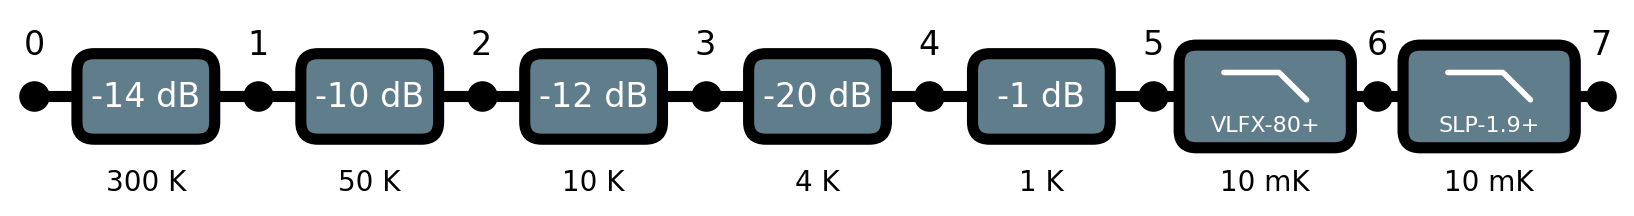

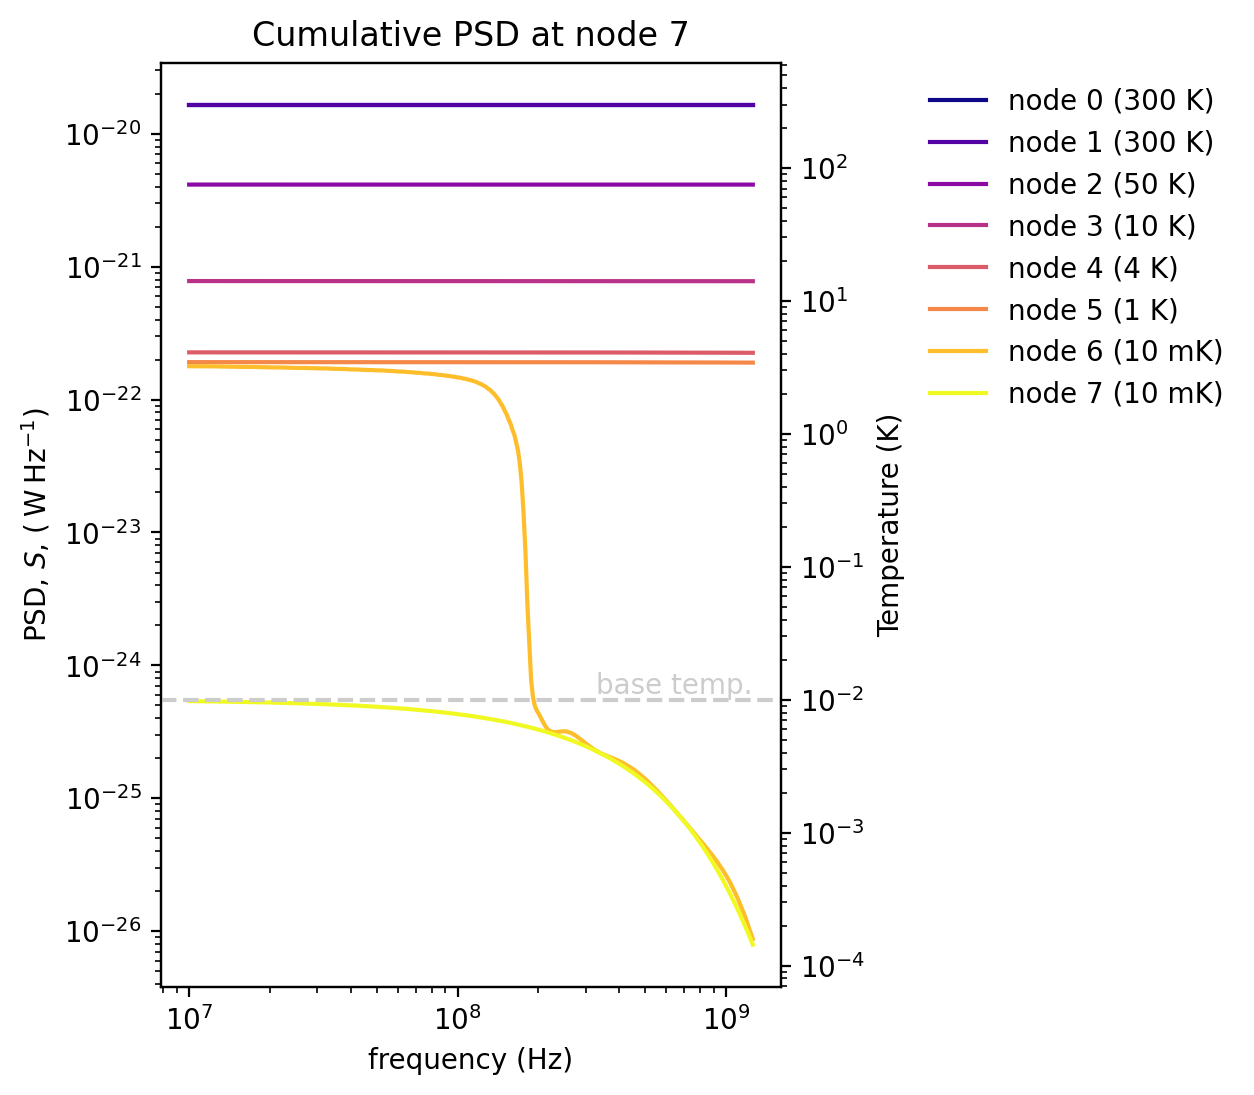

In [17]:
# Setup network
network = nt.Network(Zgen=Z0)
# flux line filtering
network.add_attenuator(attn_dB=14.4, temperature_K=300, Z0=Z0)   # RT cables
network.add_attenuator(attn_dB=10, temperature_K=50, Z0=Z0)      # 50K 
network.add_attenuator(attn_dB=12, temperature_K=10, Z0=Z0)      # cryo cables
network.add_attenuator(attn_dB=20, temperature_K=4, Z0=Z0)       # 4K 
network.add_attenuator(attn_dB=1, temperature_K=1, Z0=Z0)        # still
network.add_custom_component('VLFX-80+', temperature_K=10e-3)
network.add_custom_component('SLP-1.9+', temperature_K=10e-3)
network.draw_network()

# frequency axis
frequency = np.logspace(7, 9.1, 301)

# Plot simulated PSD
PSD = network.get_psd_at_node(frequency=frequency, initial_node_temp=300, plot=True, label=('base temp.', 10e-3))